In [1]:
%load_ext autoreload
%autoreload 2

In [82]:
from os.path import join
from glob import glob
from collections import Counter
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

from utils.io import load_json, load_pkl
from utils.video_item import VideoItem
from utils.visualize import show_single_image
from paths import VIDEO_DIR

In [3]:
mode = "val"

json_path = f"./data/{mode}_data.json"
mode_data = load_json(json_path)

In [4]:
len(mode_data)

4180

In [5]:
mode_data[10]

{'num_segments': 6,
 'description': "a deep blue lighting display is projected upon the building's face.",
 'dl_link': 'https://www.flickr.com/video_download.gne?id=8328905760',
 'times': [[0, 0], [0, 0], [0, 0], [0, 0]],
 'video': '23748404@N00_8328905760_5e0200aae1.mov',
 'annotation_id': 32787}

In [6]:
# serach video

def search_video(video_name, video_dir):
    """Search for a video in DiDeMo dataset."""
    video_path = join(video_dir, video_name + "*")
    options = glob(video_path)
    assert len(options) > 0, f"No video found at {video_path}"
    assert len(options) < 2, f"Multiple videos found with name {video_name}"
    return options[0]

In [7]:
video_name = mode_data[0]["video"]
video_dir = VIDEO_DIR

video_path = search_video(video_name, video_dir)
video_item = VideoItem(video_path)

In [8]:
# get majority vote annotation

def get_majority_vote(times: list):
    """
    Given list of times [(t1_s, t1_e), (t2_s, t2_e), .., (tK_s, tK_e)],
    find the tuple (t_s, t_e) s.t. it is a majority among the tuples.
    """
    times = [str(x) for x in times]
    c = Counter(times)
    most_common = c.most_common()
    return eval(most_common[0][0])

In [9]:
mode_data[0]["times"]

[[1, 1], [1, 1], [1, 1], [0, 0]]

In [10]:
annotation = get_majority_vote([[1,1], [2,2],[1,3],[1,3]])

In [11]:
def process_time_annotation(annotation, video_duration, truncate_video_at=30., clip_duration=5.):
    """Returns actual timestamps from annotations."""
    t_start, t_end = annotation
    t_start = t_start * clip_duration
    
    video_duration = min(truncate_video_at, video_duration)
    t_end = min((t_end + 1) * clip_duration, video_duration)
    
    return t_start, t_end

In [12]:
# video_container = video_item.load_video(video_path) 
video_duration = video_item._get_duration()

In [13]:
video_duration

39.4394

In [14]:
annotation

[1, 3]

In [15]:
t_start, t_end = process_time_annotation(annotation, video_duration, clip_duration=5.)
print(t_start, t_end)

5.0 20.0


In [16]:
fps_file = load_pkl("./data/frame_rate_clean.p")

In [17]:
video_fps = fps_file[video_name]

In [18]:
video_name, video_fps

('35034348999@N01_6060447507_dc1a90b8ef.mov', 30.0)

In [28]:
clip = video_item._get_clip(clip_start_time=t_start, clip_duration=(t_end - t_start), video_fps=video_fps)

In [29]:
clip.keys()

dict_keys(['frames', 'fps', 'start_time', 'duration'])

In [30]:
clip["fps"]

30.0

In [31]:
clip["frames"].shape

torch.Size([3, 450, 270, 479])

### Check annotations

In [109]:
description = mode_data[0]["description"]

In [51]:
entire_video = video_item._get_clip(clip_start_time=0., clip_duration=video_duration, video_fps=0.27)

In [52]:
entire_video.keys()

dict_keys(['frames', 'fps', 'start_time', 'duration'])

In [53]:
entire_video["frames"].shape

torch.Size([3, 10, 270, 479])

In [58]:
all_frames = entire_video["frames"].permute((1, 0, 2, 3))

In [59]:
all_frames.shape

torch.Size([10, 3, 270, 479])

In [54]:
grounded_clip = video_item._get_clip(clip_start_time=t_start, clip_duration=(t_end - t_start), video_fps=0.27)

In [55]:
grounded_clip["frames"].shape

torch.Size([3, 4, 270, 479])

In [57]:
grounded_clip_frames = grounded_clip["frames"]

### Visualize with annotations

In [64]:
grid = torchvision.utils.make_grid(all_frames, nrow=len(all_frames))

In [65]:
grid.shape

torch.Size([3, 274, 4812])

In [67]:
C, H, W = grid.shape
W_per_image = all_frames[0].shape[-1]

print(C, H, W, W_per_image)

3 274 4812 479


In [119]:
# draw boundix box on grounded video frames

start_frame_index = 2
end_frame_index = 6

boxes = torch.tensor([[W_per_image * start_frame_index, 5, W_per_image * end_frame_index, H]], dtype=torch.float)
colors = ["yellow"]
result = draw_bounding_boxes(grid.to(torch.uint8), boxes, colors=colors, width=10)

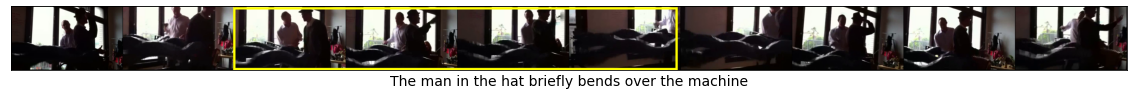

In [120]:
show_single_image(result, figsize=(20, 5), title="", xlabel=description.capitalize())